# MOSAiC initial analysis

### Science goals
- Along the possible Mosaic tracks taken from historical data, we want to plot some basic ice state information <br>
- Show the LENS members (30) on each historical track (8) --> 240 iterations
- Show ensemble mean and 1 standard deviation
- Understand when variability arises and what causes the variability


### Requirements
- Requires netcdf files of the single variable interpolated to each of the ensemble members (30) along each track (8) for each day (365) <br>
- These files were made on burnt using extract_LENS_vars_mosaic_tracks-{ice,atm}.csh with a paired ncl script <br>
- On burnt see: /project/ppc/duvivier/mosaic/analysis/along_track <br>
- The files have been moved to Cheyenne and are minimal in size. See here:/glade/p/cgd/ppc/duvivier/mosaic_along_track_subset/
- Original single variable history files on cheyenne are available for all 30 members for the two year periods starting 1981-01, 2021-01, and 2051-01. These live here: /glade/p/cgd/ppc/duvivier/mosaic/


### Loading in packages and simple xarray manipulations

In [1]:
#minimal packages needed for this activity
import xarray as xr                          #for slick netCDF operations
import numpy as np                           #for standard numeric manipulation
import matplotlib.pyplot as plt              #standard plotting library based upon Matlab functions
import pickle                                #library for saving and loading Python variables into "pickle" format
from scipy import signal                     #loading frequency analysis part of scientific computing library "scipy"
from scipy import stats                      #loading stats part of scientific computing library "scipy"
from matplotlib.gridspec import GridSpec     #for multipanel plotting

%matplotlib inline

#a couple of  constants
m2_to_millionkm2=1e6*1e6
d2r=np.pi/180

In [2]:
# Manually input start year
yy_st = 2021

# get year strings
yy_ed = yy_st+1
yy_string = str(yy_st)+'0101-'+str(yy_ed)+'1231'
print(yy_string)

20210101-20221231


In [3]:
# Manually choose input variables
ftype = 'ice'
var1 = 'aice'   # aice --> aggregate ice area (%)

# Set data path
path = '/glade/p/cgd/ppc/duvivier/mosaic/along_track_subset/'+ftype+'/'
print(path)

/glade/p/cgd/ppc/duvivier/mosaic/along_track_subset/ice/


In [4]:
# read in files
print('Opening files for '+var1)
f1 = xr.open_dataset(path+'LENS_'+var1+'_mosaic_tracks_'+yy_string+'.nc')
print('Opening',f1,'\n\n\n')

Opening files for aice
Opening <xarray.Dataset>
Dimensions:      (days_from_start: 365, ensemble: 30, year_track: 8)
Dimensions without coordinates: days_from_start, ensemble, year_track
Data variables:
    data_tracks  (year_track, ensemble, days_from_start) float64 ... 





To examine what's in these DataArrays, try printing them and their output. <br> <br>
Sometimes other Python libraries choke on DataArrays, so you often need to pull the variable out of the DataArray object into a numpy array. To do this, add the attribute ".values" to the end of the DataArray object. Numpy arrays are the standard Python object for scientific computation. More advanced data analysis techniques are found in the scipy library, and scipy functions/methods work seamlessly with numpy arrays.
 
*(Side note: methods and functions are slightly different things in Python, though they look similar and can be used in very similar ways. Functions are independent blocks of code that do not change the state of an object, have arguments, and optionally return something (e.g., library.function(ARGUMENTS)).  Methods are dependent upon Python objects (are part of the object's "class"), must be called with these objects, and can change the state of the object (e.g., object.method(PARAMETERS) or object.method()). Of course, it isn't this simple... but this quick definition should help you distinguish the methods and functions ~90% of the time.*

*(Side side note: Here's how to tell apart an object's attributes from functions/methods. Attributes have no parentheses (e.g., object.attribute), while methods/functions do (e.g., object.method(), library.function(ARG)) )*

### Playing around to understand data array and object oriented stuff

In [5]:
f1
print ('Full Data Array')
print(f1,'\n\n')

# the actual data we need to plot. Says that data_tracks is a variable in f1
f1.data_tracks
print ('data_tracks variable in data array')
print(f1.data_tracks,'\n\n')

# just shows actual values in the arrays
f1.data_tracks.values
print ('values in data_tracks')
print(f1.data_tracks.values,'\n\n')

# show the dimensions/shape of data_tracks
f1.data_tracks.values.shape
print('dimensions')
print(f1.data_tracks.values.shape,'\n\n')

# get the size of just one dimension
print('size of just year_track')
print(f1.year_track.size, '\n\n')

# all tracks start Oct.15, of the year in question. They drift for one year, set time coordinate
time = f1['days_from_start'].values
#print(time)

# get units of data_tracks
units = f1.data_tracks.units
print('units of data_tracks')
print(units, '\n\n')

# get name of data_tracks variable
long_name = f1.data_tracks.long_name
print('varname of data_tracks')
print(long_name, '\n\n')

Full Data Array
<xarray.Dataset>
Dimensions:      (days_from_start: 365, ensemble: 30, year_track: 8)
Dimensions without coordinates: days_from_start, ensemble, year_track
Data variables:
    data_tracks  (year_track, ensemble, days_from_start) float64 ... 


data_tracks variable in data array
<xarray.DataArray 'data_tracks' (year_track: 8, ensemble: 30, days_from_start: 365)>
array([[[97.069717, 96.809372, ..., 82.094604,       nan],
        [99.994408, 99.998482, ..., 96.462067,       nan],
        ...,
        [96.840179, 97.292175, ..., 97.822372,       nan],
        [98.436714, 99.186928, ..., 91.790001,       nan]],

       [[97.069717, 96.061638, ..., 13.637015, 29.006979],
        [99.994408, 99.998497, ..., 86.725967, 91.033501],
        ...,
        [96.840179, 96.966309, ..., 94.602287, 94.001617],
        [98.436714, 99.590248, ...,  1.398309,  1.833542]],

       ...,

       [[97.069717, 96.987915, ...,  3.158345,  3.252425],
        [99.994408, 99.998734, ..., 99.405472,

### Plotting --> getting more complex in order to understand what's going on

Dimensions are (see above cell)
(8, 30, 365) 

1. Plot (0,0,:) --> a single ensemble on one track
2. Plot (0,0,:) and (0,1,:) together --> two ensembles from the same track
3. Plot (0,:,:) --> all ensembles from a single track
4. Plot (:,:,:) --> all ensembles, all tracks (make grey)
5. Plot (:,:,:) in grey with mean and standard deviation overlayed in black and black dashes

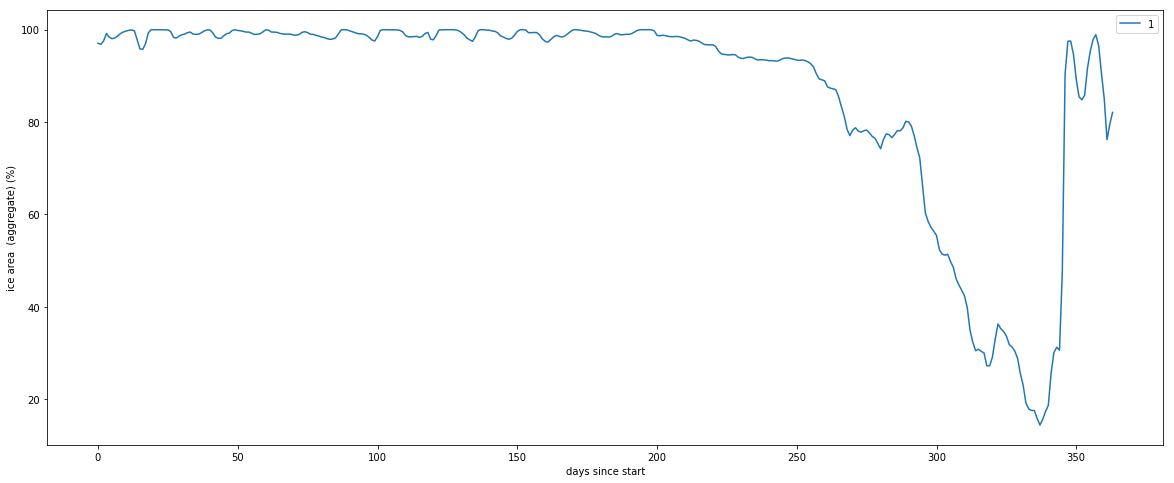

In [6]:
# 1a from above
f=plt.figure(figsize=(20,8))
plt.plot(np.arange(365),f1.data_tracks.isel(ensemble=0,year_track=0).values,label='1')
plt.xlabel('days since start')
plt.ylabel(long_name+' ('+units+')')
plt.legend();

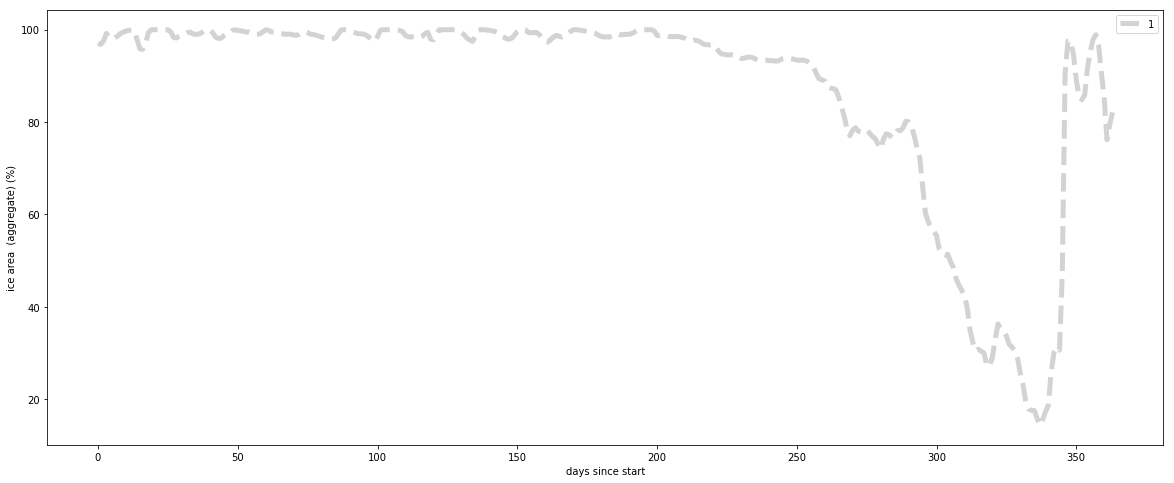

In [7]:
# 1b from above, but with color, thickness, and dash pattern modified
f=plt.figure(figsize=(20,8))
plt.plot(np.arange(365),f1.data_tracks.isel(ensemble=0,year_track=0).values,linestyle='dashed',linewidth=5,color='lightgrey',label='1')
plt.xlabel('days since start')
plt.ylabel(long_name+' ('+units+')')
plt.legend();

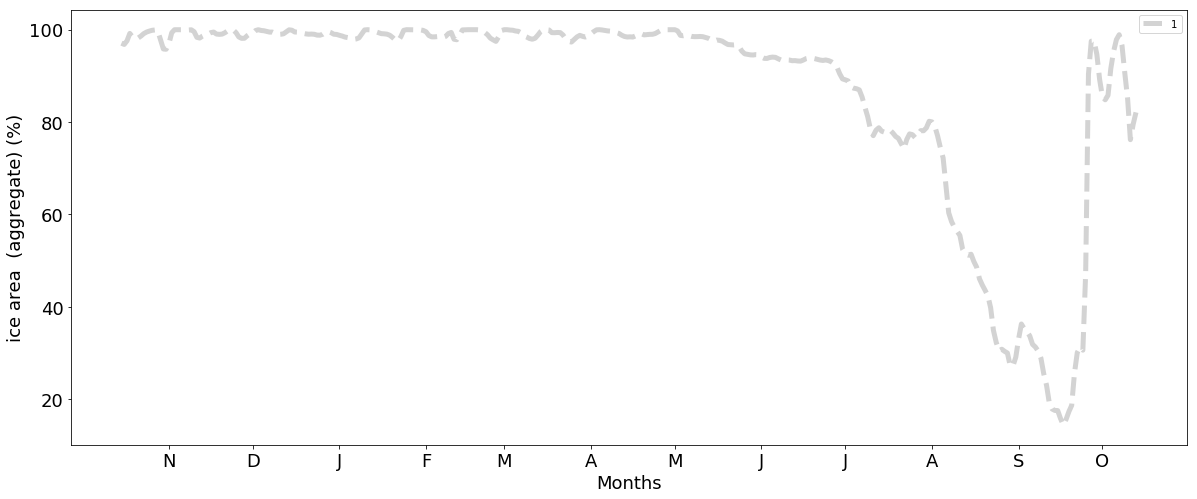

In [8]:
# 1c from above, but with labels changed and font bigger
label_inds = [17,47,78,109,137,168,198,229,259,290,321,351]
text = ['N','D','J','F','M','A','M','J','J','A','S','O']

f=plt.figure(figsize=(20,8))
plt.plot(np.arange(365),f1.data_tracks.isel(ensemble=0,year_track=0).values,linestyle='dashed',linewidth=5,color='lightgrey',label='1')
plt.xlabel('Months',size=18)
plt.ylabel(long_name+' ('+units+')',size=18)
plt.xticks(label_inds,text,size=18)
plt.yticks(size=18)
plt.legend();


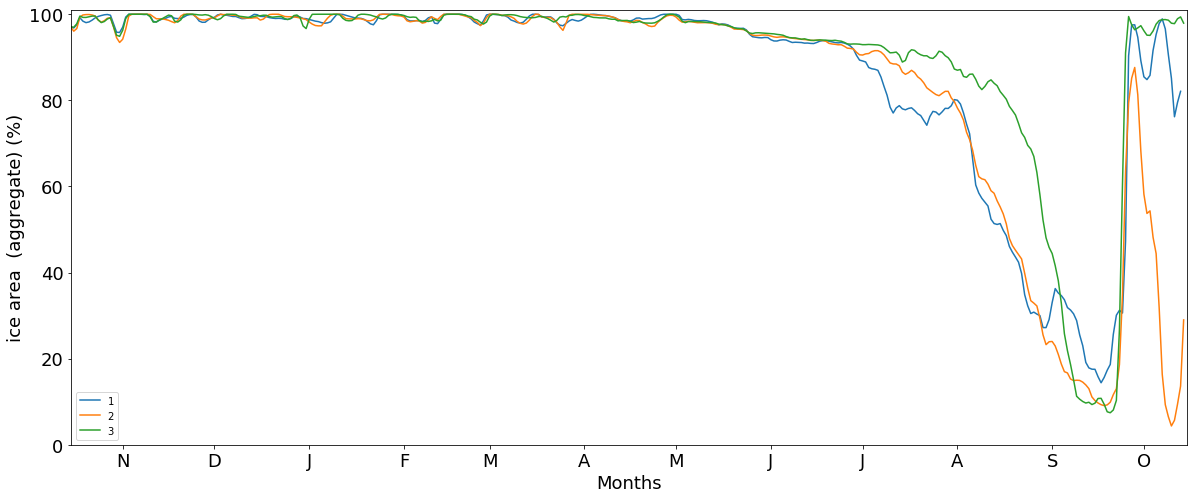

In [9]:
#2a from above, and add limits to the x and y values

f=plt.figure(figsize=(20,8))
plt.plot(np.arange(365),f1.data_tracks.isel(ensemble=0,year_track=0).values,label='1')
plt.plot(np.arange(365),f1.data_tracks.isel(ensemble=0,year_track=1).values,label='2')
plt.plot(np.arange(365),f1.data_tracks.isel(ensemble=0,year_track=2).values,label='3')
plt.xlabel('Months',size=18)
plt.ylabel(long_name+' ('+units+')',size=18)
plt.xticks(label_inds,text,size=18)
plt.yticks(size=18)
plt.legend()
plt.ylim(0,101)
plt.xlim(0,365);

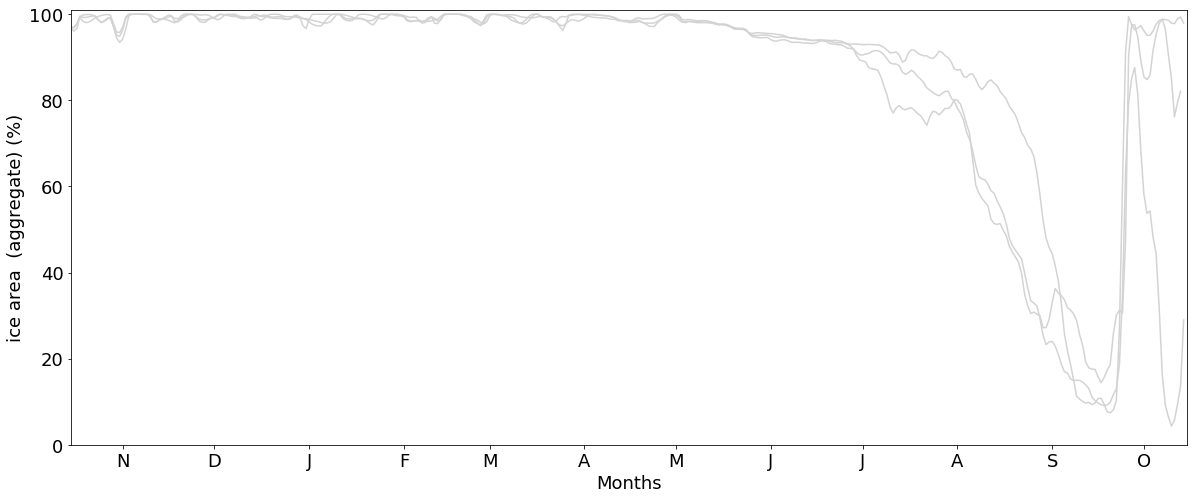

In [10]:
#2b from above, but all grey
f=plt.figure(figsize=(20,8))
plt.plot(np.arange(365),f1.data_tracks.isel(ensemble=0,year_track=0).values,color='lightgrey')
plt.plot(np.arange(365),f1.data_tracks.isel(ensemble=0,year_track=1).values,color='lightgrey')
plt.plot(np.arange(365),f1.data_tracks.isel(ensemble=0,year_track=2).values,color='lightgrey')
plt.xlabel('Months',size=18)
plt.ylabel(long_name+' ('+units+')',size=18)
plt.xticks(label_inds,text,size=18)
plt.yticks(size=18)
plt.ylim(0,101)
plt.xlim(0,365);

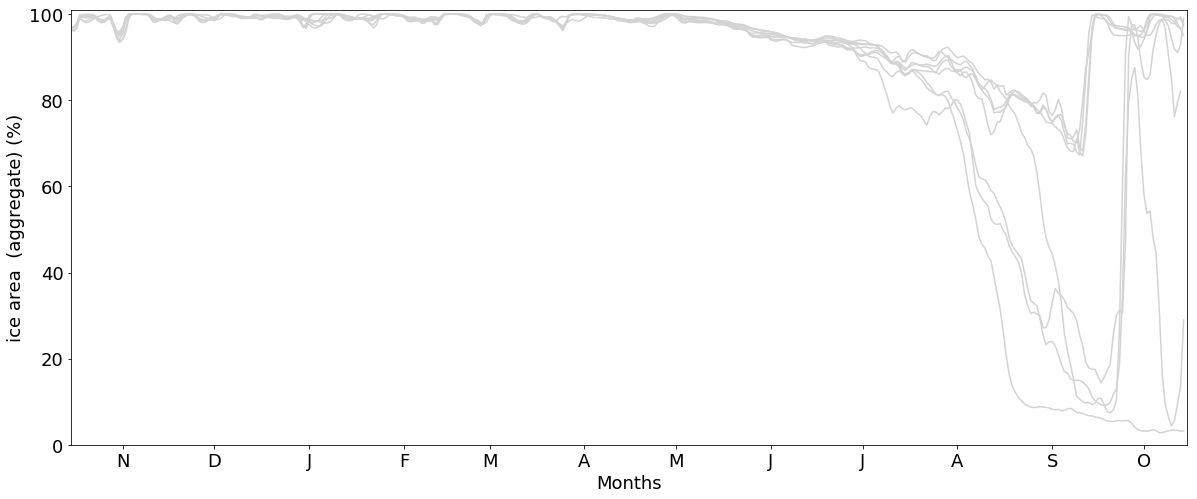

In [11]:
#3a from above and all grey
f=plt.figure(figsize=(20,8))
ens_no=0
for t in np.arange(f1.year_track.size):
    plt.plot(np.arange(365),f1.data_tracks.isel(ensemble=ens_no,year_track=t),color='lightgrey')
plt.xlabel('Months',size=18)
plt.ylabel(long_name+' ('+units+')',size=18)
plt.xticks(label_inds,text,size=18)
plt.yticks(size=18)
plt.ylim(0,101)
plt.xlim(0,365);

/gpfs/u/apps/ch/opt/python/3.6.4/intel/17.0.1/pkg-library/20180129/lib/python3.6/site-packages/xarray/plot/utils.py:51: FutureWarning: 'pandas.tseries.converter.register' has been moved and renamed to 'pandas.plotting.register_matplotlib_converters'. 
  converter.register()


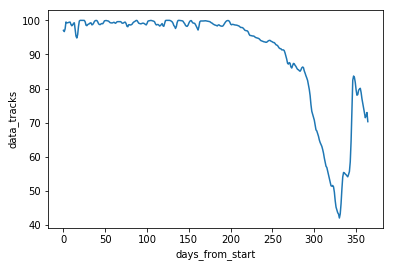

In [12]:
# just gives raw, quicky plot of output of the mean of this ensemble number for all tracks
ens_no = 0
f1.data_tracks.isel(ensemble=ens_no).mean(dim='year_track').plot()

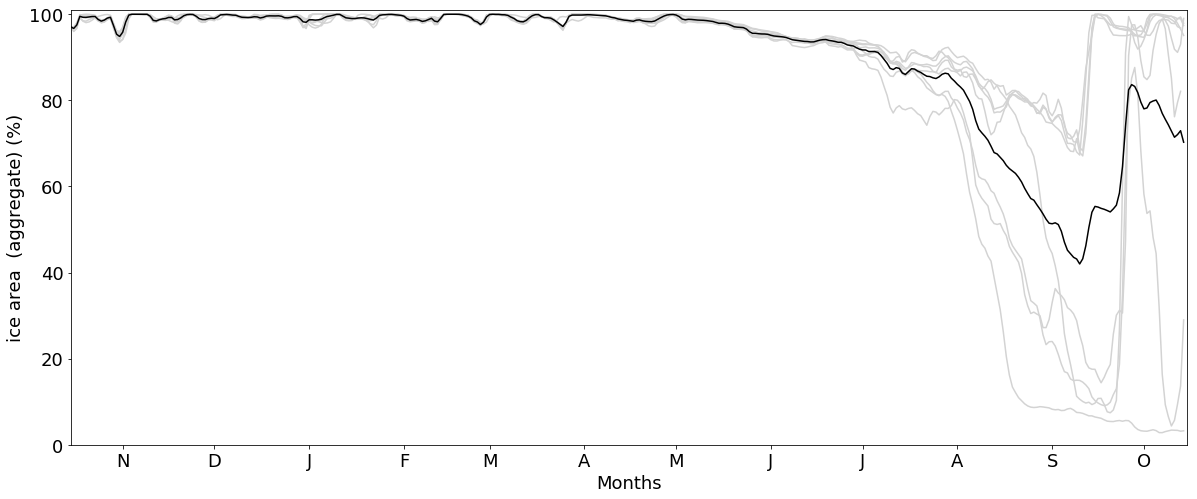

In [13]:
#3a from above and all grey with mean of this ensemble overlayed
f=plt.figure(figsize=(20,8))
ens_no=0
for t in np.arange(f1.year_track.size):
    plt.plot(np.arange(365),f1.data_tracks.isel(ensemble=ens_no,year_track=t),color='lightgrey')
plt.plot(np.arange(365),f1.data_tracks.isel(ensemble=ens_no).mean(dim='year_track'),color='black')
plt.xlabel('Months',size=18)
plt.ylabel(long_name+' ('+units+')',size=18)
plt.xticks(label_inds,text,size=18)
plt.yticks(size=18)
plt.ylim(0,101)
plt.xlim(0,365);

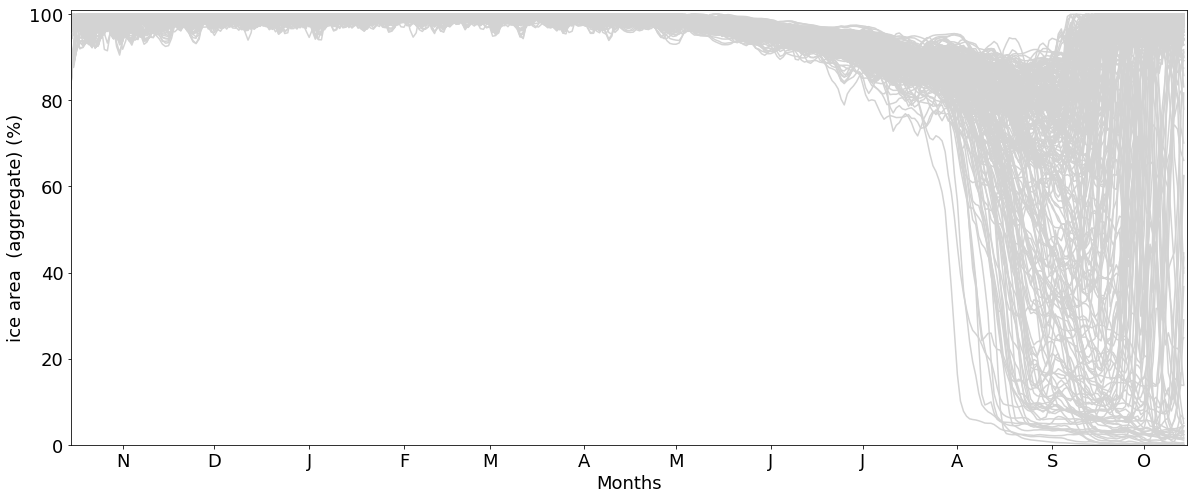

In [14]:
#4 from above
f=plt.figure(figsize=(20,8))
for e in np.arange(f1.ensemble.size):
    for t in np.arange(f1.year_track.size):
        plt.plot(np.arange(365),f1.data_tracks.isel(ensemble=e,year_track=t),color='lightgrey')
plt.xlabel('Months',size=18)
plt.ylabel(long_name+' ('+units+')',size=18)
plt.xticks(label_inds,text,size=18)
plt.yticks(size=18)
plt.ylim(0,101)
plt.xlim(0,365);

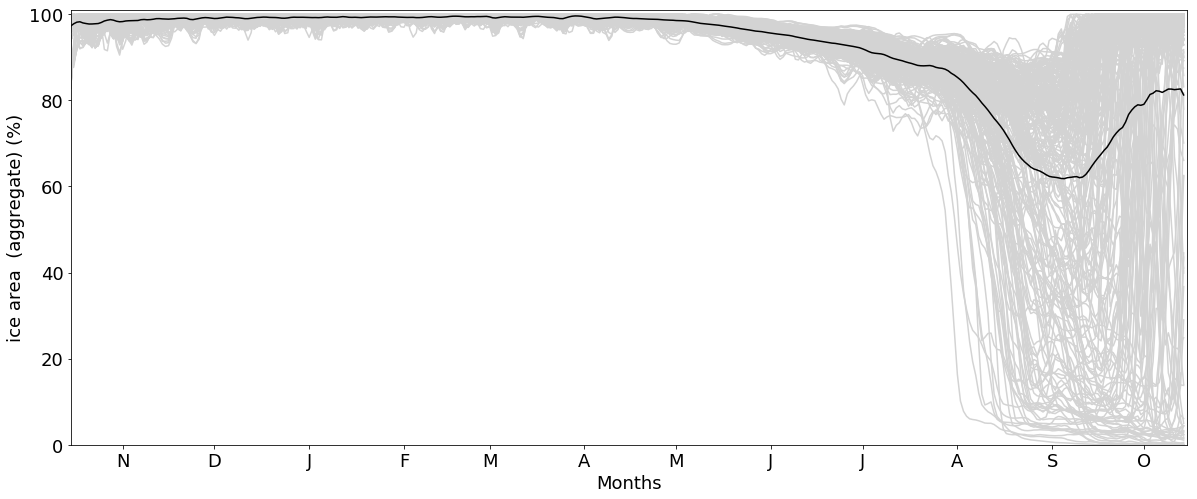

In [15]:
#5a from above
f=plt.figure(figsize=(20,8))
for e in np.arange(f1.ensemble.size):
    for t in np.arange(f1.year_track.size):
        plt.plot(np.arange(365),f1.data_tracks.isel(ensemble=e,year_track=t),color='lightgrey')
plt.plot(np.arange(365),f1.data_tracks.mean(dim=['ensemble','year_track']),color='black')
plt.xlabel('Months',size=18)
plt.ylabel(long_name+' ('+units+')',size=18)
plt.xticks(label_inds,text,size=18)
plt.yticks(size=18)
plt.ylim(0,101)
plt.xlim(0,365);

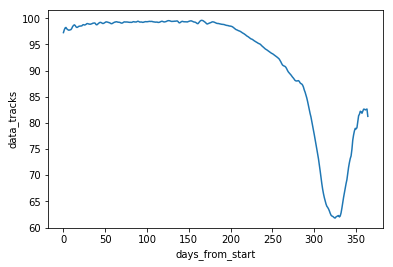

In [16]:
# mean of the entire ensemble and tracks (shown above in black)
f1.data_tracks.mean(dim=['ensemble','year_track']).plot()

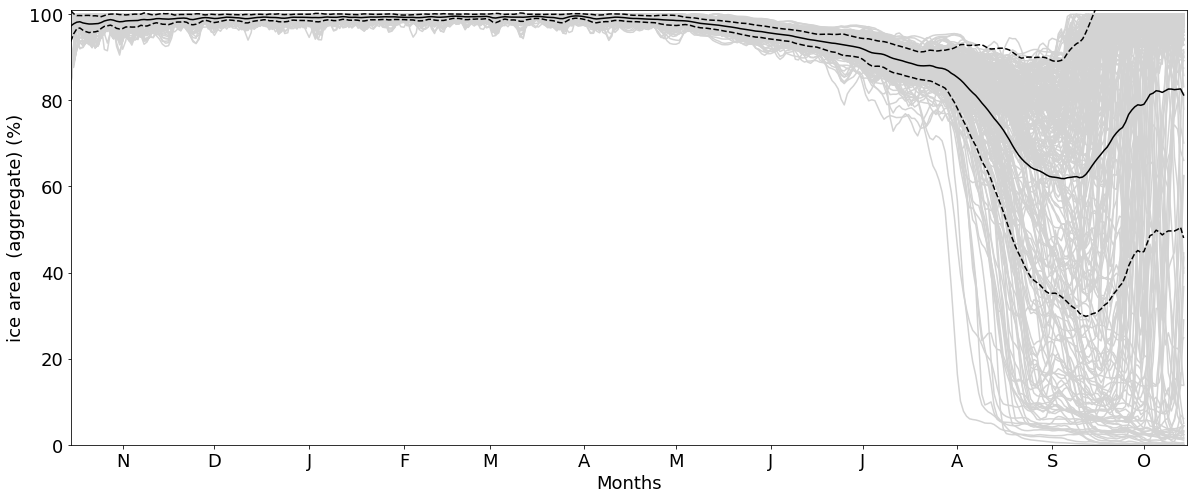

In [17]:
#5b from above, but adds +/- 1 St.Dev.
var_mean = f1.data_tracks.mean(dim=['ensemble','year_track'])
var_stdev = f1.data_tracks.std(dim=['ensemble','year_track'])

f=plt.figure(figsize=(20,8))
for e in np.arange(f1.ensemble.size):
    for t in np.arange(f1.year_track.size):
        plt.plot(np.arange(365),f1.data_tracks.isel(ensemble=e,year_track=t),color='lightgrey')
plt.plot(np.arange(365),var_mean,color='black')
plt.plot(np.arange(365),var_mean+var_stdev,color='black',linestyle='dashed')
plt.plot(np.arange(365),var_mean-var_stdev,color='black',linestyle='dashed')
plt.xlabel('Months',size=18)
plt.ylabel(long_name+' ('+units+')',size=18)
plt.xticks(label_inds,text,size=18)
plt.yticks(size=18)
plt.ylim(0,101)
plt.xlim(0,365);

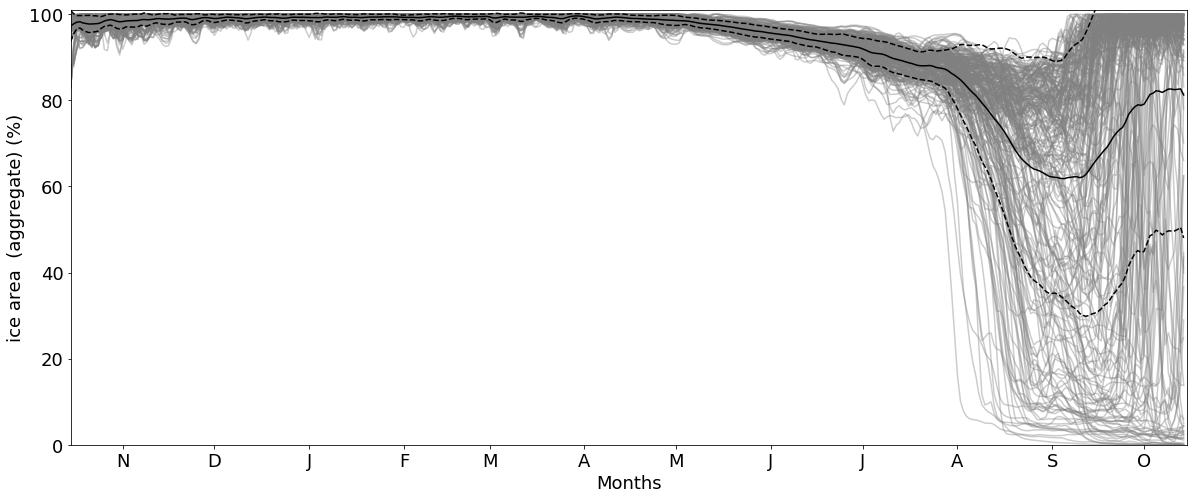

In [21]:
#5c from above, but change transparency
var_mean = f1.data_tracks.mean(dim=['ensemble','year_track'])
var_stdev = f1.data_tracks.std(dim=['ensemble','year_track'])

f=plt.figure(figsize=(20,8))
for e in np.arange(f1.ensemble.size):
    for t in np.arange(f1.year_track.size):
        plt.plot(np.arange(365),f1.data_tracks.isel(ensemble=e,year_track=t),color='grey',alpha=0.4)
plt.plot(np.arange(365),var_mean,color='black')
plt.plot(np.arange(365),var_mean+var_stdev,color='black',linestyle='dashed')
plt.plot(np.arange(365),var_mean-var_stdev,color='black',linestyle='dashed')
plt.xlabel('Months',size=18)
plt.ylabel(long_name+' ('+units+')',size=18)
plt.xticks(label_inds,text,size=18)
plt.yticks(size=18)
plt.ylim(0,101)
plt.xlim(0,365);